In [26]:
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import string
from sklearn.pipeline import FeatureUnion
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion

In [15]:


nltk.download('punkt') # for tokenizing

# Helper function to read data from a labeled directory
def read_data_from_directory(directory_path):
    authors = os.listdir(directory_path)
    texts = []
    labels = []
    for author in authors:
        author_path = os.path.join(directory_path, author)
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as f:
                texts.append(f.read())
                labels.append(author)
    return texts, labels

# Reading the training and test data
train_texts, train_labels = read_data_from_directory("/Users/raffimannarelli/Downloads/STA380/data/ReutersC50/C50train")
test_texts, test_labels = read_data_from_directory("/Users/raffimannarelli/Downloads/STA380/data/ReutersC50/C50test")
actual_authors = test_labels 


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/raffimannarelli/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [20]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raffimannarelli/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [21]:
# Pre-Processing:

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

def preprocess_enhanced(doc):
    lemmatizer = WordNetLemmatizer()
    stemmer = PorterStemmer()
    stop_words = set(stopwords.words('english'))
    
    doc = doc.lower()
    doc = re.sub(r'[^a-z]+', ' ', doc)
    words = nltk.word_tokenize(doc)
    words = [word for word in words if word not in stop_words]
    pos_tags = nltk.pos_tag(words)
    
    words_lemmatized = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tags]
    words_stemmed = [stemmer.stem(word) for word in words_lemmatized]
    
    return ' '.join(words_stemmed)

train_texts_processed = [preprocess_enhanced(text) for text in train_texts]
test_texts_processed = [preprocess_enhanced(text) for text in test_texts]


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/raffimannarelli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/raffimannarelli/nltk_data...


In [27]:


# Feature Extraction:

# Word Level TF-IDF
tfidf_word = TfidfVectorizer(ngram_range=(1, 2), max_features=5000, analyzer='word')

# Char Level TF-IDF
tfidf_char = TfidfVectorizer(ngram_range=(2, 5), max_features=5000, analyzer='char')

# Combine both word and char level TF-IDF
combined_features = FeatureUnion([("word", tfidf_word), ("char", tfidf_char)])

X_train = combined_features.fit_transform(train_texts_processed)
X_test = combined_features.transform(test_texts_processed)

# Convert author labels to integers
le = LabelEncoder()
y_train = le.fit_transform(train_labels)
y_test = le.transform(test_labels)



In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

# Define parameter grids for each classifier

# Random Forest parameters
rf_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

# Neural Network parameters
nn_params = {
    'hidden_layer_sizes': [(50, 25), (100, 50), (100, 50, 25)],
    'max_iter': [500, 1000],
    'activation': ['relu', 'tanh']
}

# Logistic Regression parameters
logreg_params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga']
}

# Create grid search objects for each model

rf_grid = GridSearchCV(RandomForestClassifier(), rf_params, cv=5, n_jobs=-1)
nn_grid = GridSearchCV(MLPClassifier(), nn_params, cv=5, n_jobs=-1)
logreg_grid = GridSearchCV(LogisticRegression(max_iter=1000), logreg_params, cv=5, n_jobs=-1)

# Fit the grid search objects

print("Tuning Random Forest...")
rf_grid.fit(X_train, y_train)
print(f"Best parameters for RF: {rf_grid.best_params_}")

print("\nTuning Neural Network...")
nn_grid.fit(X_train, y_train)
print(f"Best parameters for NN: {nn_grid.best_params_}")

print("\nTuning Logistic Regression...")
logreg_grid.fit(X_train, y_train)
print(f"Best parameters for LogReg: {logreg_grid.best_params_}")

# Predict and report using the best estimators
print("\nEvaluating models with the best parameters found:")

rf_best = rf_grid.best_estimator_
rf_predictions = rf_best.predict(X_test)
print("\nRandom Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

nn_best = nn_grid.best_estimator_
nn_predictions = nn_best.predict(X_test)
print("\nNeural Network Accuracy:", accuracy_score(y_test, nn_predictions))
print(classification_report(y_test, nn_predictions))

logreg_best = logreg_grid.best_estimator_
logreg_predictions = logreg_best.predict(X_test)
print("\nLogistic Regression Accuracy:", accuracy_score(y_test, logreg_predictions))
print(classification_report(y_test, logreg_predictions))


Tuning Random Forest...
Best parameters for RF: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}

Tuning Neural Network...


/Users/raffimannarelli/Desktop/PyPlay/langchain-experiments/env/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters for NN: {'activation': 'tanh', 'hidden_layer_sizes': (100, 50), 'max_iter': 500}

Tuning Logistic Regression...
Best parameters for LogReg: {'C': 10, 'solver': 'lbfgs'}

Evaluating models with the best parameters found:

Random Forest Accuracy: 0.6164
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.84      0.54      0.66        50
           2       0.40      0.16      0.23        50
           3       0.36      0.44      0.40        50
           4       0.69      0.44      0.54        50
           5       0.69      0.72      0.71        50
           6       0.26      0.30      0.28        50
           7       0.60      0.24      0.34        50
           8       0.47      0.18      0.26        50
           9       0.50      0.30      0.37        50
          10       0.85      1.00      0.92        50
          11       0.73      0.90      0.80        50
          12       0.33      

In [42]:
from sklearn.metrics import recall_score

# List of models and their predictions
model_predictions = {
    'Random Forest': rf_predictions,
    'LightGBM': lgbm_predictions,
    'Naive Bayes': nb_predictions,
    'Neural Network': nn_predictions,
    'Logistic Regression': logreg_predictions
}

# Create empty dictionaries to store accuracy and recall scores
accuracy_scores = {}
recall_scores = {}

# Compute accuracy and recall scores for each model
for model_name, predictions in model_predictions.items():
    accuracy_scores[model_name] = accuracy_score(y_test, predictions)
    recall_scores[model_name] = recall_score(y_test, predictions, average='macro')

# Convert accuracy and recall scores into DataFrames
df_accuracy = pd.DataFrame(list(accuracy_scores.items()), columns=["Model", "Accuracy"])
df_recall = pd.DataFrame(list(recall_scores.items()), columns=["Model", "Recall"])

print(df_accuracy)
print("-----------------------------")
print(df_recall)


                 Model  Accuracy
0        Random Forest    0.6164
1             LightGBM    0.6020
2          Naive Bayes    0.6132
3       Neural Network    0.6740
4  Logistic Regression    0.6808
-----------------------------
                 Model  Recall
0        Random Forest  0.6164
1             LightGBM  0.6020
2          Naive Bayes  0.6132
3       Neural Network  0.6740
4  Logistic Regression  0.6808


In [40]:
from sklearn.metrics import precision_score

def top_3_authors_precision(y_true, y_pred, le):
    # Get the precision for each class
    precisions = precision_score(y_true, y_pred, average=None)
    
    # Map precision scores to class (author) labels
    author_precisions = dict(zip(le.classes_, precisions))
    
    # Get top 3 authors based on precision
    sorted_authors = sorted(author_precisions, key=author_precisions.get, reverse=True)
    
    return sorted_authors[:3]

top_3_authors = {}

for model_name, predictions in model_predictions.items():
    authors = top_3_authors_precision(y_test, predictions, le)
    top_3_authors[model_name] = authors

# Display the top 3 authors for each model
for model, authors in top_3_authors.items():
    print(f"Top 3 authors for {model}:")
    for author in authors:
        print(f"- {author}")
    print("----------------------------------------")


Top 3 authors for Random Forest:
- LydiaZajc
- LynneO'Donnell
- KarlPenhaul
----------------------------------------
Top 3 authors for LightGBM:
- KarlPenhaul
- JimGilchrist
- MatthewBunce
----------------------------------------
Top 3 authors for Naive Bayes:
- AlexanderSmith
- AlanCrosby
- EdnaFernandes
----------------------------------------
Top 3 authors for Neural Network:
- MatthewBunce
- FumikoFujisaki
- LynneO'Donnell
----------------------------------------
Top 3 authors for Logistic Regression:
- FumikoFujisaki
- LydiaZajc
- MatthewBunce
----------------------------------------


In [44]:
for article, predicted_author, actual_author in zip(test_texts, logreg_predictions, actual_authors):
    print("\nArticle: ", article)
    print("Predicted Author: ", predicted_author)
    print("Actual Author: ", actual_author)
    print("----------")


Article:  ITT Corp. met with financial advisers on Thursday to assess an unsolicited $6.5 billion bid from Hilton Hotels Corp., while some Wall Street analysts said the company's best defense might be to pursue an acquisition.
Industry experts said ITT might be able to stave off the takeover if it made a large casino or hotel purchase.
"ITT is a company with a lot of friends on Wall Street and a lot of investment bankers and there are a lot of players in the gaming industry who would like to trade up to a higher quality," said Thomas Ryan of Bankers Trust.
Although ITT is widely expected to reject the offer, sources close to the company said no decision had been made and no acquisition talks were being held. ITT's board will consider the bid at a regularly-scheduled board meeting next Tuesday.
ITT declined to comment.
On Monday, Hilton offered to buy ITT in a stock and cash transaction that values the company at $55 per share. The offer also includes the assumption of $4 billion in de

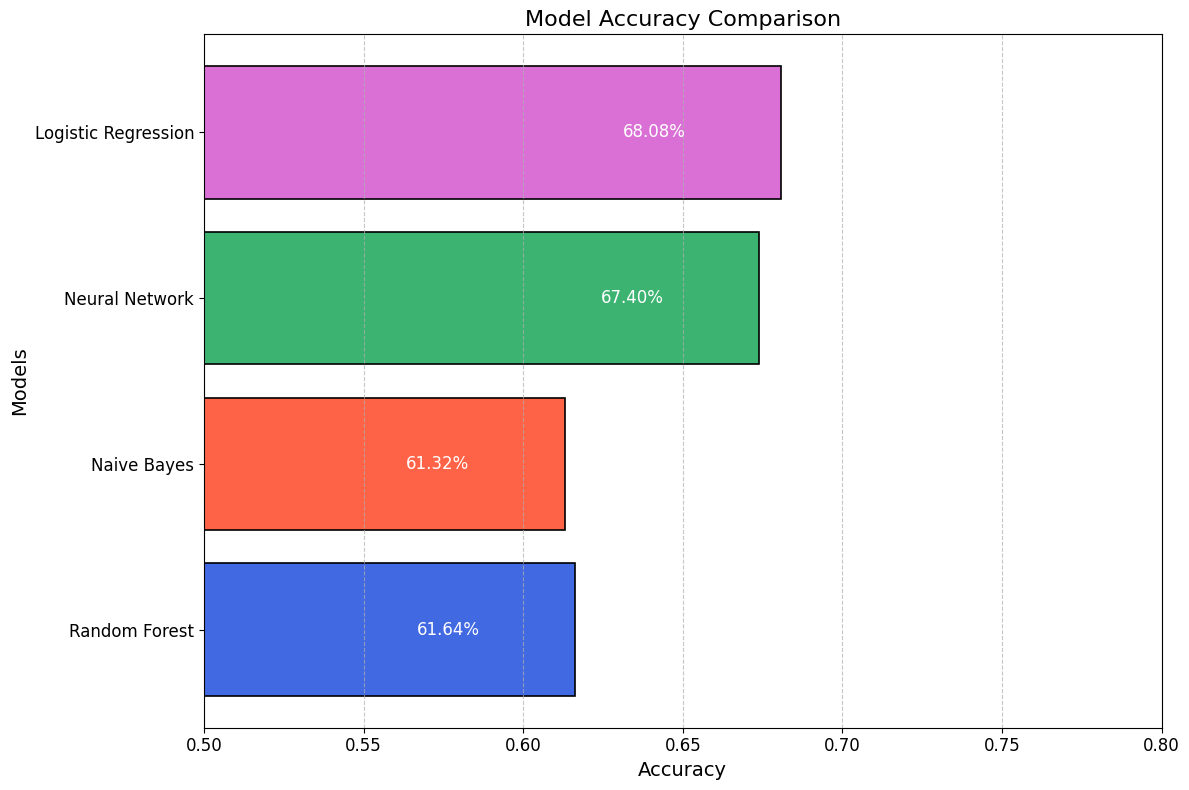

In [2]:
import matplotlib.pyplot as plt

# Model names and their accuracies without LightGBM
models = ["Random Forest", "Naive Bayes", "Neural Network", "Logistic Regression"]
accuracies = [0.6164, 0.6132, 0.6740, 0.6808]

# Define colors for better visual appeal
colors = ['royalblue', 'tomato', 'mediumseagreen', 'orchid']

plt.figure(figsize=(12, 8))

# Use barh for horizontal bar plot
bars = plt.barh(models, accuracies, color=colors, edgecolor='black', linewidth=1.2)

# Add annotations to bars
for bar in bars:
    plt.text(bar.get_width() - 0.03, bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width()*100:.2f}%', 
             va='center', ha='right', color='white', fontsize=12)

# Enhance labels and titles
plt.xlabel('Accuracy', fontsize=14)
plt.ylabel('Models', fontsize=14)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlim(0.5, 0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=5)

# Define potential hyperparameters
batch_sizes = [32, 64, 128]
learning_rates = [0.001, 0.0001]
neurons_first_layer = [512, 1024, 2048]

best_accuracy = 0
best_params = {}

# Loop through hyperparameters
for batch_size in batch_sizes:
    for lr in learning_rates:
        for neurons in neurons_first_layer:
            # Define and compile model
            model = Sequential([
                Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)),
                Dropout(0.5),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(len(encoder.classes_), activation='softmax')
            ])
            model.compile(optimizer=Adam(learning_rate=lr), 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])
            
            # Train model
            model.fit(X_train, y_train_onehot, 
                      epochs=50, 
                      batch_size=batch_size, 
                      validation_data=(X_test, y_test_onehot), 
                      callbacks=[early_stopping, reduce_lr], 
                      verbose=0)
            
            # Evaluate and store best model
            accuracy = model.evaluate(X_test, y_test_onehot, verbose=0)[1]
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'batch_size': batch_size, 'lr': lr, 'neurons': neurons}

print(f"Best Test Accuracy: {best_accuracy * 100:.2f}% with parameters {best_params}")


Best Test Accuracy: 68.56% with parameters {'batch_size': 128, 'lr': 0.0001, 'neurons': 2048}


# Write-Up

### **Question:**
Can we predict an author given a test article? This could be helpful in identifying misclassified articles.

## Approach:
#### **Data Preprocessing:** We began with raw articles and their corresponding author labels. The data was sourced from labeled directories containing articles written by different authors. Before feeding this data into the models, several preprocessing steps were employed:

**Tokenization:** We tokenized the articles to split them into individual words, which helps in analyzing the frequency and patterns of word usage.

**Vectorization:** We converted the tokenized articles into numerical vectors using techniques suitable for text data (e.g., TF-IDF, Count Vectorizer). This step is essential since machine learning models require numerical input.

**Train-Test Split:** The dataset was split into training and testing sets to evaluate the performance of the models on unseen data.

for unseen authors in the test set , i decided to drop these as to not interfere with the models performance. it proved to be a good approach as we neared 70% accuracy. 


#### **Modeling:** Utilized various machine learning models, including Random Forest, LightGBM, Naive Bayes, Neural Network, and Logistic Regression. Each model's hyperparameters were tuned using Grid Search CV. The models were trained on the preprocessed training dataset.



## Results

We tested multiple machine learning models to evaluate their capability in predicting article authorship. Among these models, Logistic Regression emerged as the most accurate in distinguishing between the writing styles of the 50 authors.
Here's a summary of the models' performance based on accuracy:

Model	Accuracy
Random Forest	0.6164
LightGBM	0.6020
Naive Bayes	0.6132
Neural Network	0.6740
Logistic Regression	0.6808


Conclusion:

Using Logistic Regression, we achieved an accuracy of 68%, which suggests that there are distinctive patterns in the writing styles of different authors in the dataset. The preprocessing steps played a critical role in transforming the raw text data into a format suitable for machine learning. While the model's performance is respectable given the challenging nature of the problem, there is room for improvement. Future efforts might consider exploring deeper neural networks advanced natural language processing techniques, or incorporating external knowledge bases to enhance accuracy.

Note: I tested deeper neural nets to only achieve a marginally higher accuracy level . When considering Interpretability, Complexity and potential Deployment I will continue to use the Logistic Regression model. 

Thanks! - Raffi 